In [45]:
## Plot Test Image by Trained Model

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("D:\EC601\dataset"))

['test', 'test.zip', 'test_ship_segmentations.csv.zip', 'train', 'train.zip', 'train_ship_segmentations.csv', 'train_ship_segmentations.csv.zip']


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = 'D:\EC601\dataset'
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')
import gc; gc.enable() # memory is tight

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [5]:
print(os.listdir("D:\EC601\dataset"))

['test', 'test.zip', 'test_ship_segmentations.csv.zip', 'train', 'train.zip', 'train_ship_segmentations.csv', 'train_ship_segmentations.csv.zip']


In [6]:
from keras import models, layers
fullres_model = models.load_model('D:\EC601\ship_detect\seg_model3.h5', compile=False)
seg_in_shape = fullres_model.get_input_shape_at(0)[1:3]
seg_out_shape = fullres_model.get_output_shape_at(0)[1:3]
print(seg_in_shape, '->', seg_out_shape)

D:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(768, 768) -> (768, 768)


In [7]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

88500 test images found


In [41]:
test_dir = 'D:\EC601\ship_detect\img'
test_paths = os.listdir(test_dir)
import os
print(os.listdir(test_dir))
print(len(test_paths), 'test images found')

['000d26c17.jpg', '00a4bf025.jpg', '00a5ebe44.jpg', '00a9be085.jpg', '00b32bc04.jpg', '00ce2c1c0.jpg', '0a0df8299.jpg', '0a1a2b14e.jpg', '0a2c6480e.jpg', '0a50e22e5.jpg']
10 test images found


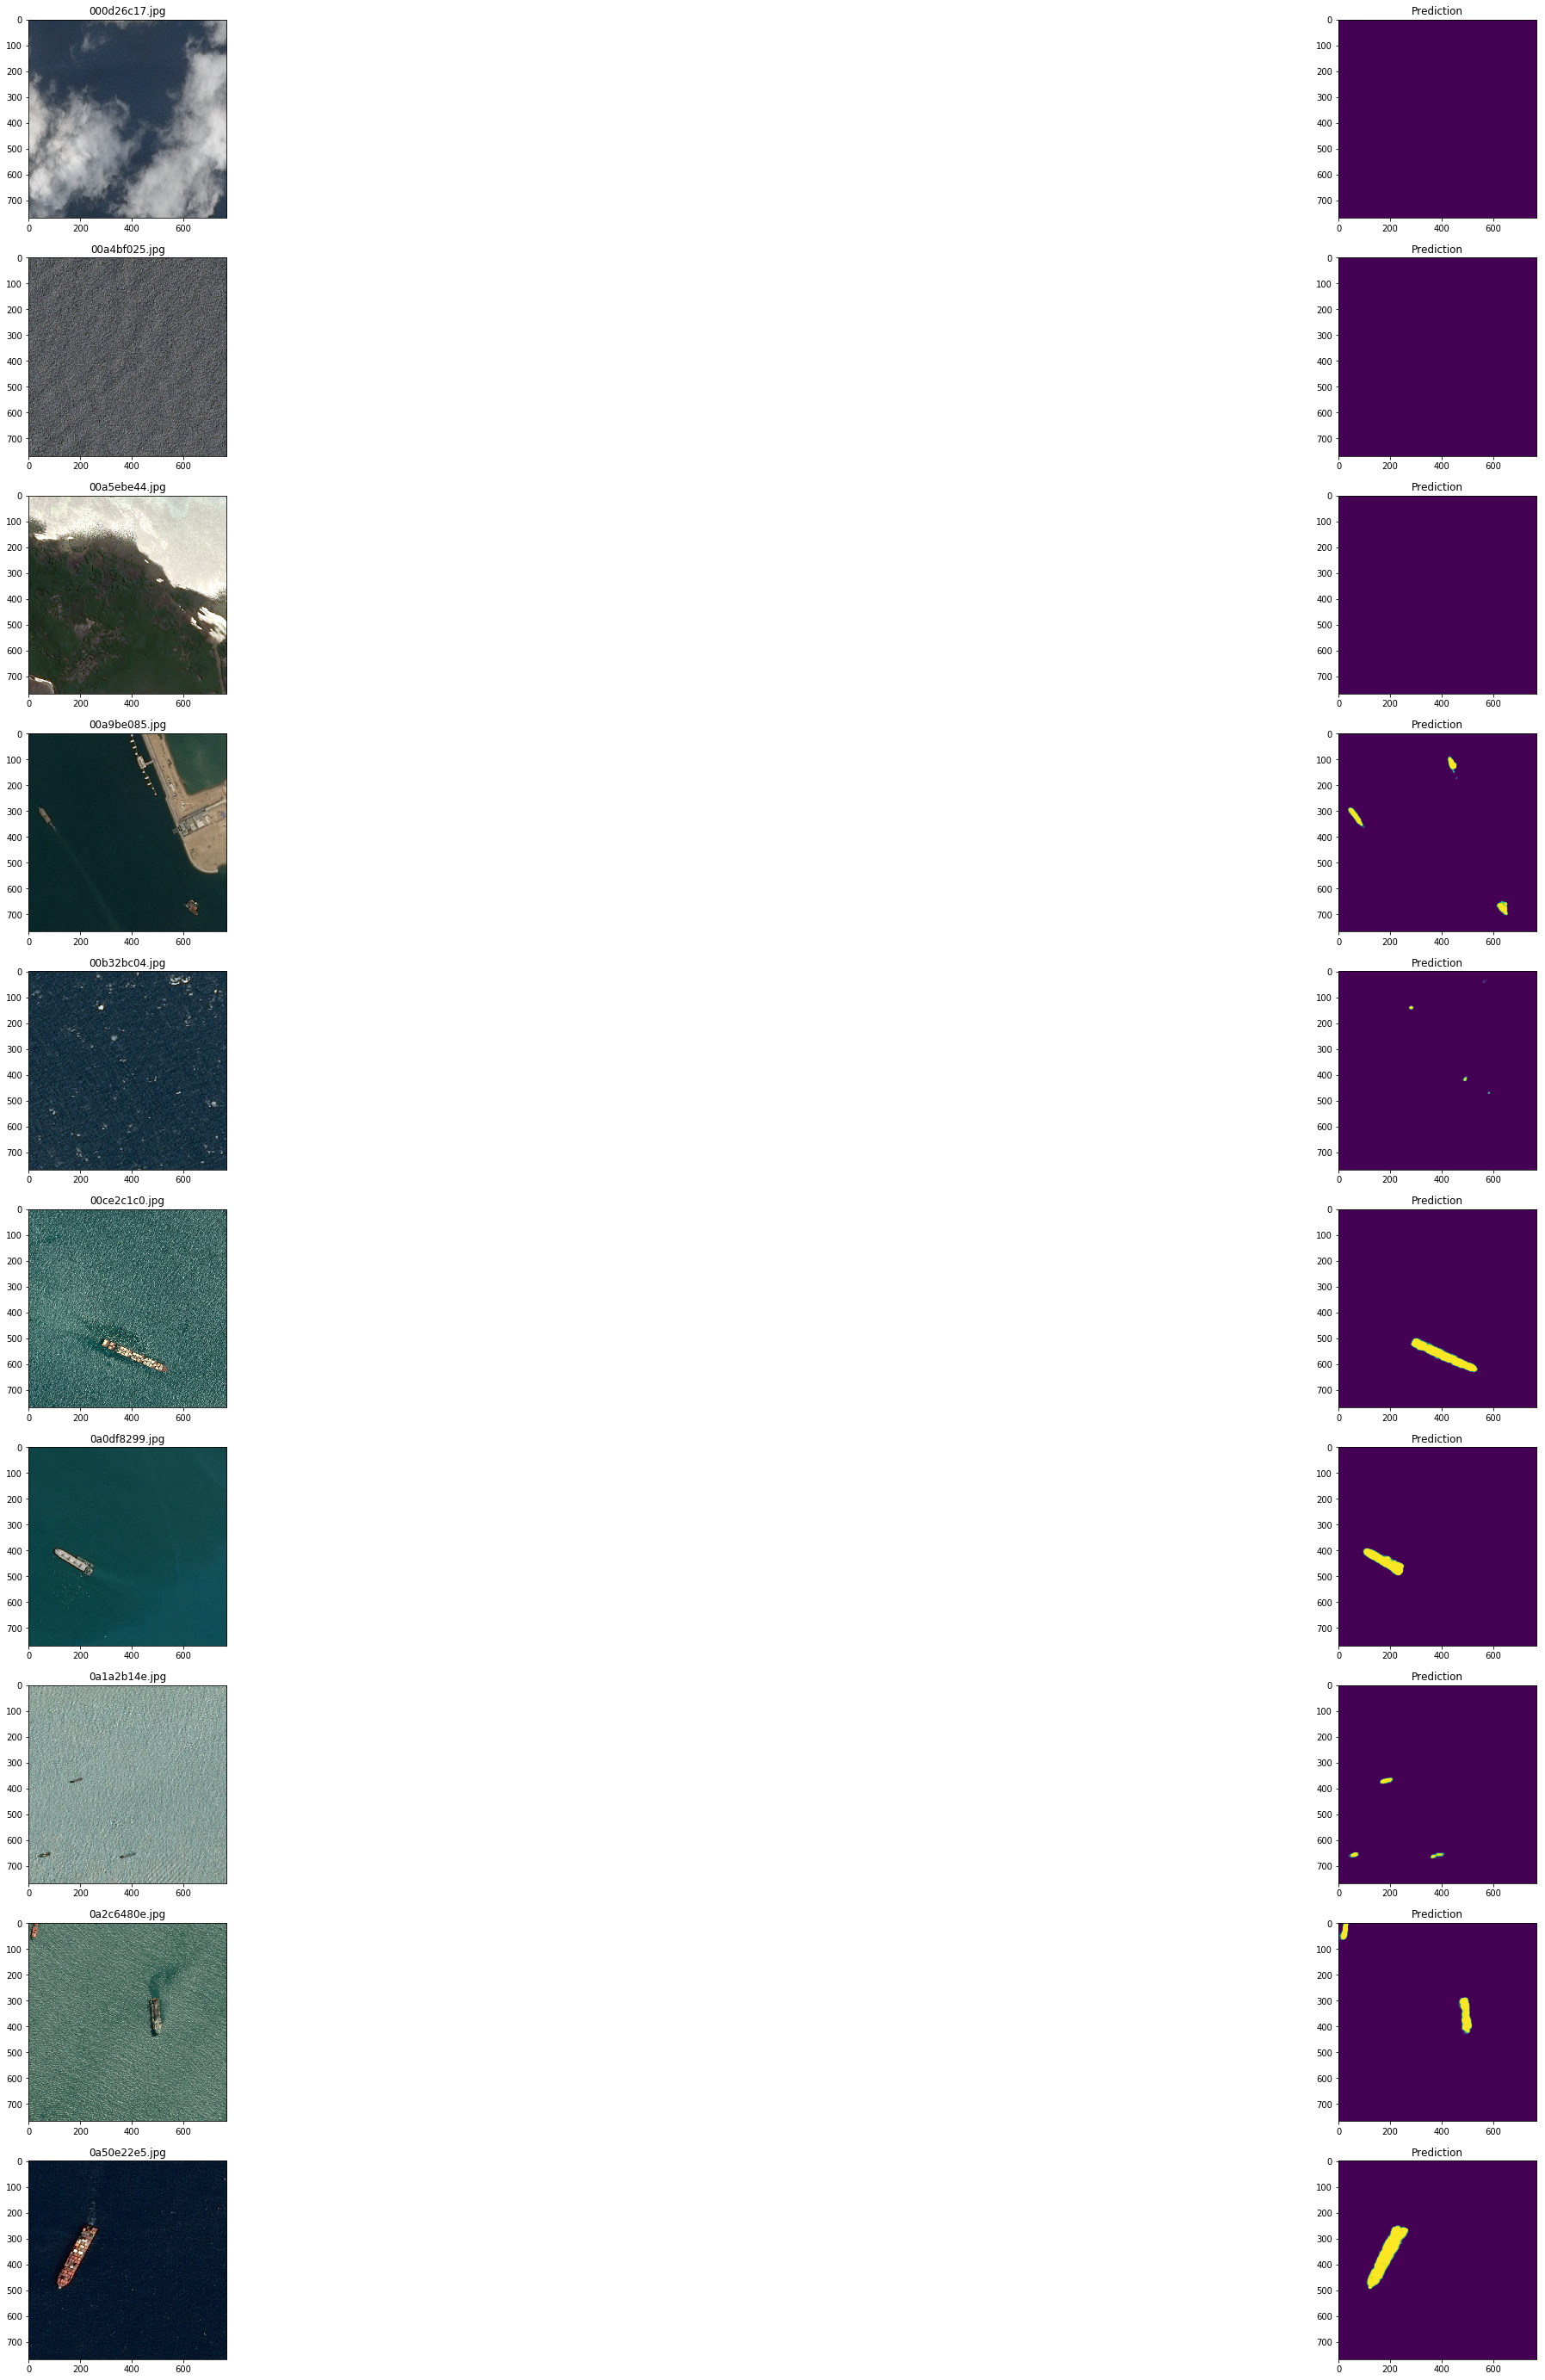

In [42]:
fig, m_axs = plt.subplots(10, 2, figsize = (50, 50))
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title(c_img_name)
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')